# DQN on the CartPole problem

In this assignment you will implement the DQN algorithm to solve a classic control problem, the CartPole.

### The CartPole problem

As the image below shows, the goal of the agent is to balance a verticle rod on the top of the car. This position is unstable and that is the main reason for the difficulty.

<img src="https://drive.google.com/uc?export=download&id=1wiFksyB3-mcirfdZEvrT2DPD7SBEjye2" >

The problem is solved if the average of the agent's scores is greater than 195 gathered in 100 episodes.
The agent receives reward 1 in each timestep until the psoition of the rod is correct (not inclined too far away from the vertical position).
The length of one episode is 200 time steps. Therefore the possible maximum score is 200.

The state is low dimensional and cosists of:
* position 
* velocity
* angle 
* angular velocity

Further details can be found on OpenAI gym's webpage: [Leader Board](https://github.com/openai/gym/wiki/CartPole-v0)

## To Solve this problem we need to know a few concepts from Reinforcement Learning.

## What is Q Learning?

Q learning is a reinforement learning technique that is used to find the best action given the current state. In Q learning a memory table of Q[state, action] is formed which stores all the possible combinations for state and action. In this at the end the agent has to act in a way to maximize the Q value function.

## What is a DQN?

DQN or Deep Q Network was invented to leverage the power of a deep neural networks in Q Learning technique of Reinforement Learning. Q learning in general is an memory and computationally intensive technique.Hence, If we take a case in a continious world such as a cartpole problem where, so many actions and states exist which make the problem computationally and memory expensive to solve simply via Q learning. So, we need to create a deep network Q-Learning function approximator. The main idea is to use a Deep Neural network to represent the Q network and train the network to predict the reward.

But, still the DQN was not very reliable in terms of convergence to the right return because of high correlation and high variance in the data. How we overcame these problems is discussed next.

## Experience replay and Iterative Update

The initial DQNs were not very stable in terms of convergence towards the right return. Hence, to assure convergence stability in DQN we introduced two techniques Experience replay and Iterative update.

1. Experience Replay : If all the data samples are sequentially taken into account these samples would have very high correlation between them which inturn makes learning process slower. To solve this problem we use experience replay.

 A replay buffer gathers experiences in a buffer and training batches are sampled according to a uniform distribution, this solves the problem of sequential data and reduces correlation problem. In addition, there are a few important experiences which are visited less number of times but should be visited a lot more times since they effect the policy strongly. Replay buffer also solves that problem of rare visits and rare experiences can be used several times.
 

2. Iterative Update : Another reason for instability of DQN is fast change (high variance) of the one-step return. In this the weights are updated frequently which leads to the network having no time to follow up changes. For this problem iterative update was introduced.

  Iterative update or (delayed update) uses two networks for representing the  Q -function. The architecture is the same but the weights are different. The weights are synchronized after a given number of steps. This solves the problem of fast change

With the help of these techniques we were able to successfully implement the cartpole problem with the help of DQNs quite successfully.

In [ ]:
%matplotlib inline
%tensorflow_version 1.x
import matplotlib.pyplot as plt
import gym 
from gym.wrappers import Monitor
import numpy as np
import random
from enum import Enum
from skimage import transform as trf
from keras.models import Sequential # Keras: highlevel API above dnn libraries (tendorflow, cntr, theano)
from keras.layers import Dense, Convolution2D, Flatten
from keras.optimizers import Adam, SGD, RMSprop

TensorFlow 1.x selected.


Using TensorFlow backend.


In [ ]:
class Optimizer(Enum): # Enum, Makes easier to try different optimizers
    ADAM = 1
    RMSPROP = 2
    SGD = 3

In [ ]:
# The implementation of DQN.
class Dqn:
    
    def __init__(self, params):         
        self.env = None                       # The environment where the RL agent will learn.
        self.buffer_size = params.buf_size    # The maximum size of the experience replay.
        self.batch_size = params.batch        # Batch size during training.
        self.epoch = params.epoch             # For one training cycle, the number epoch on a batch.
        self.max_episode = params.max_ep      # The number of episodes for training.
        self.eps0 = params.eps                # The starting value of epsilon in the epsilon-greedy policy.
        self.gamma = params.gamma             # Discounting factor.
        self.C = params.C                     # Frequency of synchronizing the frozen network.
        self.train_freq = params.train_freq   # Update frequency for the not frozen network.
        self.eval_freq = params.eval_freq     # Evaluation frequency.
        self.net = params.net                 # The description of the network. List of tuples. A tuple: (number of units, activation)
        self.lr = params.lr                   # learning rate
        self.opt = params.opt                 # Optimizer.

        self.q_cont, self.q_frzn = None, None # two networks for training: continuously updated and frozen

        self.buffer = []  # experience replay
        
        self.env = gym.make('CartPole-v0')
        self.env.reset()
        self.q_cont, self.q_frzn = self._init_models()
    
    # ------------------------------------------------------
    # functions for inicialization
    
    def _init_optimizer(self):

        optz = None
        if self.opt == Optimizer.ADAM:
            optz = Adam(self.lr)
        elif self.opt == Optimizer.SGD:
            optz = SGD(self.lr)
        elif self.opt == Optimizer.RMSPROP:
            optz = RMSprop(self.lr)

        return optz

    # The network builds up from Dense layers (similar to the fully connected)
    def _init_models(self):
        
        def build(strc):
            # strc - list of tuples
            # each tuple contains: number of nodes in the dense layer, activation function name (e.g.: 'relu')
            # ----- implement this -----
            q =Sequential()  # ----- create a sequential model -----
            # ----- add a dense layer with input_shape 4 (4 frames will be stacked) -----
            # use the strc for accessing the required parameters
            q.add(Dense(strc[0][0], activation = strc[0][1], input_shape = (4,))) #initial input layer


            for i in range(1, len(strc)):
                # ----- add the remaining dense layers to the model
                q.add(Dense(strc[i][0], activation = strc[i][1])) #stacking layers


            optz = self._init_optimizer()
            # compile the model with an appropriate loss function
            q.compile(loss = 'mse', optimizer = optz) #since the neural network is trying to predict the accurate reward value we use mse as the loss function

            return q #returns neural network

        q_cont = build(self.net)  # continuously updated network (Q-function)
        q_frzn = build(self.net)  # frozen network

        q_cont.set_weights(q_frzn.get_weights())  # synchronization

        return q_cont, q_frzn

    def _init_buffer(self, number):
        # gathers 'number' pieces of experiences randomly
        # ----- study and undertand this piece of code carefully -----
        exps = []
        obs, rw, done, _ = self.env.step(0)
        for _ in range(number):

            if done:
                obs = self.env.reset()

            action = self.env.action_space.sample()  # sampling random actions from the environment
            obs_next, rw, done, _ = self.env.step(action)  # taking the step and observe the results
            exps.append((obs, rw, action, done, obs_next))  # we append a new experience
            obs = obs_next

        self.append(exps)  # you will implement this function
    
    def close(self):
        self.env.close()

    def train_function(self):
        
        # initializing experience replay with random experiences
        self._init_buffer(self.batch_size)

        print("Initialization was finished.")
        print("Training was started.")

        ep_id = 1
        cntr = 0
        eval_permitted = True
        rtn = 0
        exps = []
        
        ep_ids = []
        returns = []

        eps = self.eps0
        self.env.reset()
        obs, _, done, _ = self.env.step(0)

        while ep_id < self.max_episode:

            cntr += 1

            if done:
                if ep_id % 10 == 0:
                    print('Episode Id: ' + str(ep_id) + ' Return during training: ' + str(rtn))
                rtn = 0
                ep_id += 1
                eval_permitted = True
                obs = self.env.reset() # when an episode ends (done = True) the environment is reseted
            
            action = self.select_action_epsilon(obs, eps)  # ---- select the next action with epsilon greedy -----

            obs_next, rw, done, _ = self.env.step(action)  # ----- take a new step with the environment -----
            rtn += rw
            
            if done:                     ## calculating return
                if rtn < 180:
                    rw = -1
                    obs_next *= 0.0
                    obs *= 0.0
                elif rtn >= 180:
                    rw = 100

            exps.append((obs, rw, action, done, obs_next))
            obs = obs_next

            if cntr % 128 == 0:
                self.append(exps)
                exps.clear()
            
            # training
            if  cntr % self.train_freq == 0:
              # ----- sample experiences from the replay then train q_cont with them
              s1,s2 = self.sample(self.batch_size)
              self.q_cont.fit(s1, s2, epochs = self.epoch, batch_size = self.batch_size, verbose = False)
                
            ## this part deals with the iterative update
            # synchronizing the frozen network
            if cntr % self.C == 0:
              self.q_frzn.set_weights(self.q_cont.get_weights())

            # evaluating at the current stage of learning
            if ep_id % self.eval_freq == 0 and eval_permitted:
                r = self.evaluation()
                ep_ids.append(ep_id)
                returns.append(r)
                #print('EValuation at episode: ' + str(ep_id) + ' -> ' +  str(r))
                eval_permitted = False
                if r >= 185:
                    break
            
            # Decrasing the epsilon value for epsilon-greedy. Exploration -> exploitation
            eps = max(eps - 0.001, 0.01)

        print("Training was finished.")
        return ep_ids, returns

    def evaluation(self, video=False): 
        
        orig_env = self.env
        if video:
            self.env = Monitor(orig_env, 'videos/cartpole', force=True)

        obs = self.env.reset()
        done = False
        rtn = 0
        ep_id = 0
        rtns = []

        while ep_id < 50:

            if done:
                rtns.append(rtn)
                rtn = 0
                ep_id += 1
                obs = self.env.reset()

            action = self.select_action_epsilon(obs, 0.01)
            obs, rw, done, _ = self.env.step(action)
            rtn += rw

        self.env = orig_env
        return np.mean(rtns)

    # ------------------------------------------------------
    # Functions for handling the experience replay

    def clear_buffer(self):
        self.buffer.clear()

    # The new experiences are added at the end of the buffer.
    # The too old experiences are deleted.
    def append(self, experiences):
        # experiences - list of experiences
        # ----- implement this -----
        
        # ----- check if appending the new set of experiences to the buffer has enough space -----
        if self.buffer_size < (len(experiences) + len(self.buffer)):#checks if it has enough space
          # ----- if not, delete as many experiences as required -----
          self.buffer = self.buffer[len(experiences)- (self.buffer_size - len(self.buffer)):]#the part after the negative sign deletes the required number of values
            

        self.buffer += experiences  # finally we append the new experiences to the buffer

    def sample(self, number):
        exps = random.sample(self.buffer, number)    # experiences list
        obs = np.stack([x[0] for x in exps], axis=0) # numpy array is used by keras, for creating a batch observations should be stacked
       


        rws = np.stack([x[1] for x in exps], axis=0) # ----- do similar stacking for the rewards -----
        acts = np.stack([x[2] for x in exps], axis=0) # ----- implement this too -----
        dones = np.stack([x[3] for x in exps], axis=0) # ----- implement this too -----
        next_obs = np.stack([x[4] for x in exps], axis=0) # ----- implement this too -----


# In the following two lines you take the frozen and the unfrozen networks and predict the next observation with a given batch size. 
# This is literally what you have done many time when you take a trained model and execute the predic function

        q_vals = self.q_cont.predict(obs) # ----- predict (forward execute) with q_cont on obs -----   # q_vals size should be: (batch_size, 2)
        fzn_q_vals = self.q_frzn.predict(next_obs) # ----- predict with q_frzn on next_obs -----
        
        # The action function is represented by a network.
        # The input of this network is the state, 
        # the output is the set of action-values
        # corresponding to the actions.
        # So the number of outputs is equal with the nunmber of actions.
        # In training we sample one transition at a time, therefore we have loss
        # for only one output (action) at a time.
        # But for training, we have to provide information for all of the outputs.
        # How can we solve this?

 #  The sub_values are the rws plus the max of the frozen values times the discounted max of the frozen values. You thus do not need the intermediate step. You are predicting for the next observation already, so you already have the next value. 
        sub_values = rws + self.gamma * np.amax(fzn_q_vals,axis = 1)  # ----- calculate this according to the one-step return for Q-learning -----
        q_vals[list(range(number)), acts] = sub_values  # this will be the target during training

        x = obs.astype(dtype=np.float32)
        y = q_vals.astype(dtype=np.float32)

        return x, y

    # ------------------------------------------------------
    # Choosing an action

    # epsilon-greedy
    def select_action_epsilon(self, state, eps):  # state shape: (4) nunmpy array
        s = np.expand_dims(state, axis=0)
        max_idx = np.argmax(self.q_cont.predict(s, batch_size=1))
        if np.random.random() < 1 - eps:
            return max_idx
        return (max_idx + 1) % 2 # now we have only two actions

    # no epsilon-greedy
    def select_action(self, state):
        s = np.expand_dims(state, axis=0)
        return np.argmax(self.q_cont.predict(s, batch_size=1))

In [ ]:
class Parameters:

    def __init__(self):
                                 # Default values
        self.buf_size = 5000     # 5000
        self.batch = 256         # 256
        self.epoch = 5           # 5
        self.max_ep = 500        # 500
        self.eps = 0.5           # 0.5
        self.gamma = 0.9         # 0.9
        self.C = 100             # 100
        self.train_freq = 1      # 1
        self.eval_freq = 10      # 10
        self.net = [(128, 'relu'), (128, 'relu'), (2, 'relu')] # [(128, 'relu'), (128, 'relu'), (2, 'relu')]
        self.lr = 0.0001         # 0.0001
        self.opt = Optimizer.ADAM # Optimizer.ADAM

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Initialization was finished.
Training was started.

Episode Id: 10 Return during training: 10.0
Episode Id: 20 Return during training: 13.0
Episode Id: 30 Return during training: 13.0
Episode Id: 40 Return during training: 11.0
Episode Id: 50 Return during training: 10.0
Episode Id: 60 Return during training: 14.0
Episode Id: 70 Return during training: 30.0
Episode Id: 80 Return during training: 41.0
Episode Id: 90 Return during training: 34.0
Episode Id: 100 Return during training: 66.0
Episode Id: 110 Return during training: 116.0
Episode Id: 120 Return during training: 125.0
Episode Id: 130 Return during training: 120.0
Episode Id: 140 Return during training: 144.0
Episode Id: 150 Return during training: 134.0
Episode Id: 160 Return during training: 130.0
Episode Id: 170 Return during training: 165.0
Episode Id: 180 Return during training: 169.0
Training was finished.


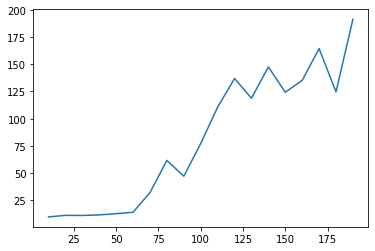

In [ ]:
# Running the training and evaluation
pms = Parameters()
dqn = Dqn(pms)
ep_ids, returns = dqn.train_function()
plt.plot(ep_ids, returns)
dqn.evaluation(video=False)
dqn.close()

### Question:

* Does it converge all the time?
* What happens if you change the default parameters?

Answers to the above two questions are at the end of notebook after all the explorations

# Exploration of Different Parameters

## Batch Size

In [ ]:
#Batch size of 128
class Parameters:

    def __init__(self):
                                 # Default values
        self.buf_size = 5000     # 5000
        self.batch = 128         # 256
        self.epoch = 5           # 5
        self.max_ep = 500        # 500
        self.eps = 0.5           # 0.5
        self.gamma = 0.9         # 0.9
        self.C = 100             # 100
        self.train_freq = 1      # 1
        self.eval_freq = 10      # 10
        self.net = [(128, 'relu'), (128, 'relu'), (2, 'relu')] # [(128, 'relu'), (128, 'relu'), (2, 'relu')]
        self.lr = 0.0001         # 0.0001
        self.opt = Optimizer.ADAM # Optimizer.ADAM

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Initialization was finished.
Training was started.

Episode Id: 10 Return during training: 12.0
Episode Id: 20 Return during training: 11.0
Episode Id: 30 Return during training: 12.0
Episode Id: 40 Return during training: 12.0
Episode Id: 50 Return during training: 11.0
Episode Id: 60 Return during training: 12.0
Episode Id: 70 Return during training: 32.0
Episode Id: 80 Return during training: 27.0
Episode Id: 90 Return during training: 24.0
Episode Id: 100 Return during training: 49.0
Episode Id: 110 Return during training: 55.0
Episode Id: 120 Return during training: 126.0
Episode Id: 130 Return during training: 167.0
Episode Id: 140 Return during training: 28.0
Episode Id: 150 Return during training: 9.0
Episode Id: 160 Return during training: 200.0
Episode Id: 170 Return during training: 17.0
Episode Id: 180 Return during training: 70.0
Episode Id: 190 Return during training: 84.0
Episode Id: 200 Ret

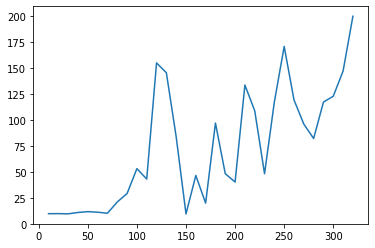

In [ ]:
# Running the training and evaluation
pms = Parameters()
dqn = Dqn(pms)
ep_ids, returns = dqn.train_function()
plt.plot(ep_ids, returns)
dqn.evaluation(video=False)
dqn.close()

In [ ]:
#Batch size of 512
class Parameters:

    def __init__(self):
                                 # Default values
        self.buf_size = 5000     # 5000
        self.batch = 512         # 256
        self.epoch = 5           # 5
        self.max_ep = 500        # 500
        self.eps = 0.5           # 0.5
        self.gamma = 0.9         # 0.9
        self.C = 100             # 100
        self.train_freq = 1      # 1
        self.eval_freq = 10      # 10
        self.net = [(128, 'relu'), (128, 'relu'), (2, 'relu')] # [(128, 'relu'), (128, 'relu'), (2, 'relu')]
        self.lr = 0.0001         # 0.0001
        self.opt = Optimizer.ADAM # Optimizer.ADAM

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Initialization was finished.
Training was started.

Episode Id: 10 Return during training: 16.0
Episode Id: 20 Return during training: 15.0
Episode Id: 30 Return during training: 10.0
Episode Id: 40 Return during training: 10.0
Episode Id: 50 Return during training: 11.0
Episode Id: 60 Return during training: 14.0
Episode Id: 70 Return during training: 53.0
Episode Id: 80 Return during training: 18.0
Episode Id: 90 Return during training: 16.0
Episode Id: 100 Return during training: 38.0
Episode Id: 110 Return during training: 156.0
Episode Id: 120 Return during training: 12.0
Episode Id: 130 Return during training: 10.0
Episode Id: 140 Return during training: 37.0
Episode Id: 150 Return during training: 46.0
Episode Id: 160 Return during training: 200.0
Episode Id: 170 Return during training: 33.0
Episode Id: 180 Return during training: 40.0
Episode Id: 190 Return during training: 118.0
Episode Id: 200 Re

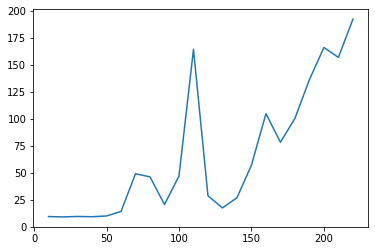

In [ ]:
# Running the training and evaluation
from tensorflow.keras import backend as be
be.clear_session()
pms = Parameters()
dqn = Dqn(pms)
ep_ids, returns = dqn.train_function()
plt.plot(ep_ids, returns)
dqn.evaluation(video=False)
dqn.close()

In [ ]:
#Batch size of 32
class Parameters:

    def __init__(self):
                                 # Default values
        self.buf_size = 5000     # 5000
        self.batch = 32         # 512
        self.epoch = 5           # 5
        self.max_ep = 500        # 500
        self.eps = 0.5           # 0.5
        self.gamma = 0.9         # 0.9
        self.C = 100             # 100
        self.train_freq = 1      # 1
        self.eval_freq = 10      # 10
        self.net = [(128, 'relu'), (128, 'relu'), (2, 'relu')] # [(128, 'relu'), (128, 'relu'), (2, 'relu')]
        self.lr = 0.0001         # 0.0001
        self.opt = Optimizer.ADAM # Optimizer.ADAM

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Initialization was finished.
Training was started.

Episode Id: 10 Return during training: 10.0
Episode Id: 20 Return during training: 11.0
Episode Id: 30 Return during training: 10.0
Episode Id: 40 Return during training: 10.0
Episode Id: 50 Return during training: 10.0
Episode Id: 60 Return during training: 10.0
Episode Id: 70 Return during training: 14.0
Episode Id: 80 Return during training: 10.0
Episode Id: 90 Return during training: 12.0
Episode Id: 100 Return during training: 12.0
Episode Id: 110 Return during training: 14.0
Episode Id: 120 Return during training: 27.0
Episode Id: 130 Return during training: 10.0
Episode Id: 140 Return during training: 25.0
Episode Id: 150 Return during training: 22.0
Episode Id: 160 Return during training: 21.0
Episode Id: 170 Return during training: 16.0
Episode Id: 180 Return during training: 25.0
Episode Id: 190 Return during training: 26.0
Episode Id: 200 Retur

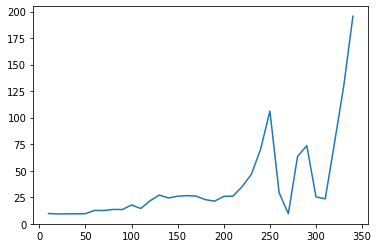

In [ ]:
# Running the training and evaluation
from tensorflow.keras import backend as be
be.clear_session()
pms = Parameters()
dqn = Dqn(pms)
ep_ids, returns = dqn.train_function()
plt.plot(ep_ids, returns)
dqn.evaluation(video=False)
dqn.close()

## Summary for Batch Size

Explored different batch sizes of 32, 128 and 512 other than default of 256. Rest all parameters were kept as default parameters. For all of the different values of batch sizes tried above the system (DQN agent) converged. In terms of lower batch sizes (32 and 128) the system converged in over 300 episodes which is more than the default value convergence and with higher batch size value of 512 the convergence is around 200 episodes which is around the same value as default parameters. Hence, it seems like the default batch size of 256 is optimal.

## Exploring buffer size:


In [ ]:
#buffer size of 2500 
class Parameters:

    def __init__(self):
                                 # Default values
        self.buf_size = 2500     # 5000
        self.batch = 256         # 256
        self.epoch = 5           # 5
        self.max_ep = 500        # 500
        self.eps = 0.5           # 0.5
        self.gamma = 0.9         # 0.9
        self.C = 100             # 100
        self.train_freq = 1      # 1
        self.eval_freq = 10      # 10
        self.net = [(128, 'relu'), (128, 'relu'), (2, 'relu')] # [(128, 'relu'), (128, 'relu'), (2, 'relu')]
        self.lr = 0.0001         # 0.0001
        self.opt = Optimizer.ADAM # Optimizer.ADAM


Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Initialization was finished.
Training was started.

Episode Id: 10 Return during training: 17.0
Episode Id: 20 Return during training: 9.0
Episode Id: 30 Return during training: 10.0
Episode Id: 40 Return during training: 10.0
Episode Id: 50 Return during training: 9.0
Episode Id: 60 Return during training: 12.0
Episode Id: 70 Return during training: 20.0
Episode Id: 80 Return during training: 55.0
Episode Id: 90 Return during training: 27.0
Episode Id: 100 Return during training: 96.0
Episode Id: 110 Return during training: 10.0
Episode Id: 120 Return during training: 9.0
Episode Id: 130 Return during training: 10.0
Episode Id: 140 Return during training: 200.0
Episode Id: 150 Return during training: 200.0
Episode Id: 160 Return during training: 14.0
Training was finished.


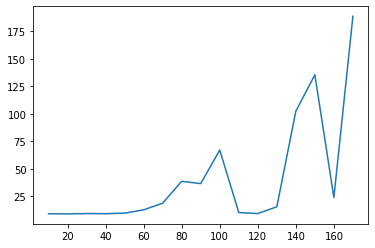

In [ ]:
# Running the training and evaluation
from tensorflow.keras import backend as be
be.clear_session()
pms = Parameters()
dqn = Dqn(pms)
ep_ids, returns = dqn.train_function()
plt.plot(ep_ids, returns)
dqn.evaluation(video=False)
dqn.close()

In [ ]:
#buffer size of 10000
class Parameters:

    def __init__(self):
                                 # Default values
        self.buf_size = 10000     # 5000
        self.batch = 256         # 256
        self.epoch = 5           # 5
        self.max_ep = 500        # 500
        self.eps = 0.5           # 0.5
        self.gamma = 0.9         # 0.9
        self.C = 100             # 100
        self.train_freq = 1      # 1
        self.eval_freq = 10      # 10
        self.net = [(128, 'relu'), (128, 'relu'), (2, 'relu')] # [(128, 'relu'), (128, 'relu'), (2, 'relu')]
        self.lr = 0.0001         # 0.0001
        self.opt = Optimizer.ADAM # Optimizer.ADAM

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Initialization was finished.
Training was started.

Episode Id: 10 Return during training: 10.0
Episode Id: 20 Return during training: 14.0
Episode Id: 30 Return during training: 11.0
Episode Id: 40 Return during training: 11.0
Episode Id: 50 Return during training: 11.0
Episode Id: 60 Return during training: 9.0
Episode Id: 70 Return during training: 14.0
Episode Id: 80 Return during training: 22.0
Episode Id: 90 Return during training: 34.0
Episode Id: 100 Return during training: 31.0
Episode Id: 110 Return during training: 77.0
Episode Id: 120 Return during training: 161.0
Training was finished.


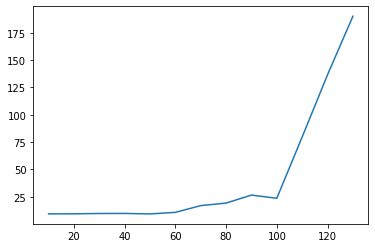

In [ ]:
# Running the training and evaluation
from tensorflow.keras import backend as be
be.clear_session()
pms = Parameters()
dqn = Dqn(pms)
ep_ids, returns = dqn.train_function()
plt.plot(ep_ids, returns)
dqn.evaluation(video=False)
dqn.close()

## Summary for Buffer Size:

Explored buffer size of 2500 and 10000, which are half and double of the default buffer size respectively. Rest of the parameters were kept as default. In both the cases the DQN system converged. In the case of smaller buffer size (2500) the number of episodes required to converge were around 170 and in case of higher buffer size the system converged on around 130 episodes. Additionally, the convergence of smaller buffer size is also very irratic compared to larger buffer size. Hence bigger the buffer size faster and smoother seems for the system/agent to converge 

## Exploring Gamma (Discounting Factor)

In [ ]:
#Gamma of 0.85
class Parameters:

    def __init__(self):
                                 # Default values
        self.buf_size = 5000     # 5000
        self.batch = 256         # 256
        self.epoch = 5           # 5
        self.max_ep = 500        # 500
        self.eps = 0.5           # 0.5
        self.gamma = 0.85         # 0.9
        self.C = 100             # 100
        self.train_freq = 1      # 1
        self.eval_freq = 10      # 10
        self.net = [(128, 'relu'), (128, 'relu'), (2, 'relu')] # [(128, 'relu'), (128, 'relu'), (2, 'relu')]
        self.lr = 0.0001         # 0.0001
        self.opt = Optimizer.ADAM # Optimizer.ADAM

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Initialization was finished.
Training was started.

Episode Id: 10 Return during training: 10.0
Episode Id: 20 Return during training: 9.0
Episode Id: 30 Return during training: 14.0
Episode Id: 40 Return during training: 9.0
Episode Id: 50 Return during training: 11.0
Episode Id: 60 Return during training: 9.0
Episode Id: 70 Return during training: 10.0
Episode Id: 80 Return during training: 47.0
Episode Id: 90 Return during training: 35.0
Episode Id: 100 Return during training: 185.0
Episode Id: 110 Return during training: 76.0
Episode Id: 120 Return during training: 98.0
Episode Id: 130 Return during training: 78.0
Episode Id: 140 Return during training: 112.0
Episode Id: 150 Return during training: 129.0
Episode Id: 160 Return during training: 151.0
Episode Id: 170 Return during training: 39.0
Episode Id: 180 Return during training: 198.0
Episode Id: 190 Return during training: 83.0
Episode Id: 200 Ret

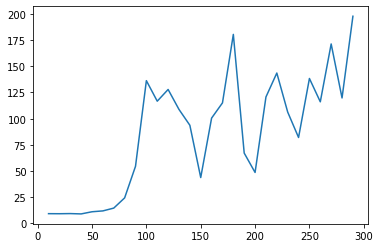

In [ ]:
# Running the training and evaluation
from tensorflow.keras import backend as be
be.clear_session()
pms = Parameters()
dqn = Dqn(pms)
ep_ids, returns = dqn.train_function()
plt.plot(ep_ids, returns)
dqn.evaluation(video=False)
dqn.close()

In [ ]:
#Gamma of 0.95
class Parameters:

    def __init__(self):
                                 # Default values
        self.buf_size = 5000     # 5000
        self.batch = 256         # 256
        self.epoch = 5           # 5
        self.max_ep = 500        # 500
        self.eps = 0.5           # 0.5
        self.gamma = 0.95         # 0.9
        self.C = 100             # 100
        self.train_freq = 1      # 1
        self.eval_freq = 10      # 10
        self.net = [(128, 'relu'), (128, 'relu'), (2, 'relu')] # [(128, 'relu'), (128, 'relu'), (2, 'relu')]
        self.lr = 0.0001         # 0.0001
        self.opt = Optimizer.ADAM # Optimizer.ADAM

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Initialization was finished.
Training was started.

Episode Id: 10 Return during training: 10.0
Episode Id: 20 Return during training: 14.0
Episode Id: 30 Return during training: 11.0
Episode Id: 40 Return during training: 10.0
Episode Id: 50 Return during training: 9.0
Episode Id: 60 Return during training: 10.0
Episode Id: 70 Return during training: 9.0
Episode Id: 80 Return during training: 12.0
Episode Id: 90 Return during training: 16.0
Episode Id: 100 Return during training: 23.0
Episode Id: 110 Return during training: 19.0
Episode Id: 120 Return during training: 18.0
Episode Id: 130 Return during training: 17.0
Episode Id: 140 Return during training: 19.0
Episode Id: 150 Return during training: 18.0
Episode Id: 160 Return during training: 17.0
Episode Id: 170 Return during training: 27.0
Episode Id: 180 Return during training: 37.0
Episode Id: 190 Return during training: 77.0
Episode Id: 200 Return 

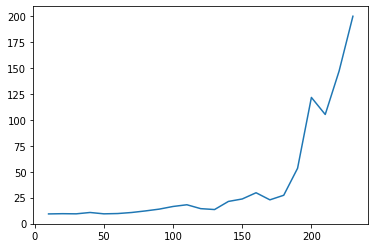

In [ ]:
# Running the training and evaluation
from tensorflow.keras import backend as be
be.clear_session()
pms = Parameters()
dqn = Dqn(pms)
ep_ids, returns = dqn.train_function()
plt.plot(ep_ids, returns)
dqn.evaluation(video=False)
dqn.close()

## Summary for Gamma (Discounting Factor)

Explored 0.85 and 0.95 values of gamma which are 0.05 higher and lower than the default value of 0.9 and rest of the parameters were kept the same as default. In both the above mentioned cases the DQN system converges. In case of gamma = 0.85 the system takes more than 300 episodes to converge which is higher than both the default value of 0.9 which takes around 190 episode and the other explored value of 0.95. In case of gamma = 0.95 the system converges quite quickly in around 200 episodes and further the convergence of the system is much smoother than 0.9 and 0.85. Where as in the case of gamma = 0.85 the convergence is very erratic as seen in the plot. Hence, it seems like higher the value of gamma smoother and faster the convergence.

## Exploring Optimizers.

These are the optimizers for the deep neural network.

In [ ]:
#Optimizer = SGD
class Parameters:

    def __init__(self):
                                 # Default values
        self.buf_size = 5000     # 5000
        self.batch = 256         # 256
        self.epoch = 5           # 5
        self.max_ep = 500        # 500
        self.eps = 0.5           # 0.5
        self.gamma = 0.9         # 0.9
        self.C = 100             # 100
        self.train_freq = 1      # 1
        self.eval_freq = 10      # 10
        self.net = [(128, 'relu'), (128, 'relu'), (2, 'relu')] # [(128, 'relu'), (128, 'relu'), (2, 'relu')]
        self.lr = 0.0001         # 0.0001
        self.opt = Optimizer.SGD # Optimizer.ADAM

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Initialization was finished.
Training was started.

Episode Id: 10 Return during training: 15.0
Episode Id: 20 Return during training: 12.0
Episode Id: 30 Return during training: 9.0
Episode Id: 40 Return during training: 12.0
Episode Id: 50 Return during training: 8.0
Episode Id: 60 Return during training: 12.0
Episode Id: 70 Return during training: 9.0
Episode Id: 80 Return during training: 10.0
Episode Id: 90 Return during training: 11.0
Episode Id: 100 Return during training: 10.0
Episode Id: 110 Return during training: 9.0
Episode Id: 120 Return during training: 9.0
Episode Id: 130 Return during training: 10.0
Episode Id: 140 Return during training: 8.0
Episode Id: 150 Return during training: 11.0
Episode Id: 160 Return during training: 9.0
Episode Id: 170 Return during training: 10.0
Episode Id: 180 Return during training: 10.0
Episode Id: 190 Return during training: 9.0
Episode Id: 200 Return during

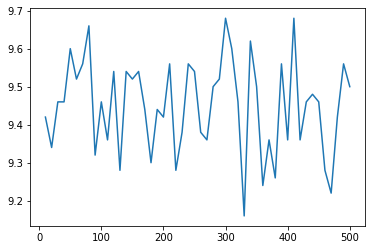

In [ ]:
# Running the training and evaluation
from tensorflow.keras import backend as be
be.clear_session()
pms = Parameters()
dqn = Dqn(pms)
ep_ids, returns = dqn.train_function()
plt.plot(ep_ids, returns)
dqn.evaluation(video=False)
dqn.close()

In [ ]:
#Optimizer
class Parameters:

    def __init__(self):
                                 # Default values
        self.buf_size = 5000     # 5000
        self.batch = 256         # 256
        self.epoch = 5           # 5
        self.max_ep = 500        # 500
        self.eps = 0.5           # 0.5
        self.gamma = 0.9         # 0.9
        self.C = 100             # 100
        self.train_freq = 1      # 1
        self.eval_freq = 10      # 10
        self.net = [(128, 'relu'), (128, 'relu'), (2, 'relu')] # [(128, 'relu'), (128, 'relu'), (2, 'relu')]
        self.lr = 0.0001         # 0.0001
        self.opt = Optimizer.RMSPROP # Optimizer.ADAM

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Initialization was finished.
Training was started.

Episode Id: 10 Return during training: 13.0
Episode Id: 20 Return during training: 17.0
Episode Id: 30 Return during training: 14.0
Episode Id: 40 Return during training: 13.0
Episode Id: 50 Return during training: 30.0
Episode Id: 60 Return during training: 27.0
Episode Id: 70 Return during training: 54.0
Episode Id: 80 Return during training: 39.0
Episode Id: 90 Return during training: 53.0
Episode Id: 100 Return during training: 57.0
Episode Id: 110 Return during training: 87.0
Episode Id: 120 Return during training: 84.0
Episode Id: 130 Return during training: 93.0
Episode Id: 140 Return during training: 134.0
Episode Id: 150 Return during training: 29.0
Episode Id: 160 Return during training: 158.0
Episode Id: 170 Return during training: 136.0
Episode Id: 180 Return during training: 132.0
Episode Id: 190 Return during training: 135.0
Episode Id: 200 

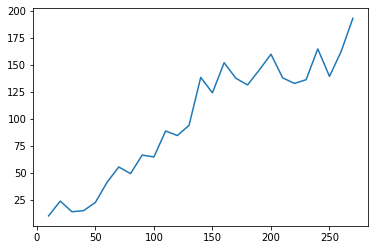

In [ ]:
# Running the training and evaluation
from tensorflow.keras import backend as be
be.clear_session()
pms = Parameters()
dqn = Dqn(pms)
ep_ids, returns = dqn.train_function()
plt.plot(ep_ids, returns)
dqn.evaluation(video=False)
dqn.close()

## Summary for Optimizers

I tried 2 other optimizers RMSprop and SGD with other parameters as the default values. In case of RMSprop the DQN system converged and the system learned consistently and convereged to the optimal value of the return, But, in the case of SGD and default values of the rest of the parameters the system is not able to learn a lot and is not converging with just 500 episodes probably we need to explore this a bit more. Currently adam seem to be the best optimizer for this.

## Exploration : Learning Rate
Learning Rate of the Deep Neural Network

In [ ]:
#Learning Rate = 0.001
class Parameters:

    def __init__(self):
                                 # Default values
        self.buf_size = 5000     # 5000
        self.batch = 256         # 256
        self.epoch = 5           # 5
        self.max_ep = 500        # 500
        self.eps = 0.5           # 0.5
        self.gamma = 0.9         # 0.9
        self.C = 100             # 100
        self.train_freq = 1      # 1
        self.eval_freq = 10      # 10
        self.net = [(128, 'relu'), (128, 'relu'), (2, 'relu')] # [(128, 'relu'), (128, 'relu'), (2, 'relu')]
        self.lr = 0.001         # 0.0001
        self.opt = Optimizer.ADAM # Optimizer.ADAM

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Initialization was finished.
Training was started.

Episode Id: 10 Return during training: 20.0
Episode Id: 20 Return during training: 27.0
Episode Id: 30 Return during training: 76.0
Episode Id: 40 Return during training: 67.0
Episode Id: 50 Return during training: 120.0
Episode Id: 60 Return during training: 129.0
Episode Id: 70 Return during training: 16.0
Episode Id: 80 Return during training: 50.0
Episode Id: 90 Return during training: 57.0
Episode Id: 100 Return during training: 90.0
Episode Id: 110 Return during training: 200.0
Episode Id: 120 Return during training: 119.0
Training was finished.


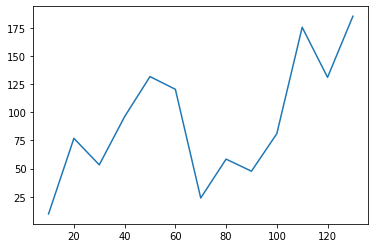

In [ ]:
# Running the training and evaluation
from tensorflow.keras import backend as be
be.clear_session()
pms = Parameters()
dqn = Dqn(pms)
ep_ids, returns = dqn.train_function()
plt.plot(ep_ids, returns)
dqn.evaluation(video=False)
dqn.close()

In [ ]:
#Learning Rate = 0.01
class Parameters:

    def __init__(self):
                                 # Default values
        self.buf_size = 5000     # 5000
        self.batch = 256         # 256
        self.epoch = 5           # 5
        self.max_ep = 500        # 500
        self.eps = 0.5           # 0.5
        self.gamma = 0.9         # 0.9
        self.C = 100             # 100
        self.train_freq = 1      # 1
        self.eval_freq = 10      # 10
        self.net = [(128, 'relu'), (128, 'relu'), (2, 'relu')] # [(128, 'relu'), (128, 'relu'), (2, 'relu')]
        self.lr = 0.01         # 0.0001
        self.opt = Optimizer.ADAM # Optimizer.ADAM

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Initialization was finished.
Training was started.

Episode Id: 10 Return during training: 23.0
Episode Id: 20 Return during training: 10.0
Episode Id: 30 Return during training: 11.0
Episode Id: 40 Return during training: 10.0
Episode Id: 50 Return during training: 23.0
Episode Id: 60 Return during training: 10.0
Episode Id: 70 Return during training: 11.0
Episode Id: 80 Return during training: 9.0
Episode Id: 90 Return during training: 10.0
Episode Id: 100 Return during training: 11.0
Episode Id: 110 Return during training: 19.0
Episode Id: 120 Return during training: 40.0
Training was finished.


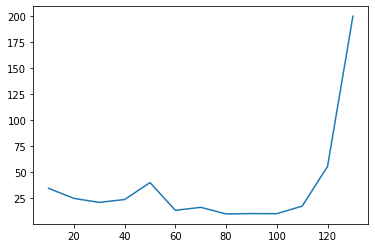

In [ ]:
# Running the training and evaluation
from tensorflow.keras import backend as be
be.clear_session()
pms = Parameters()
dqn = Dqn(pms)
ep_ids, returns = dqn.train_function()
plt.plot(ep_ids, returns)
dqn.evaluation(video=False)
dqn.close()

In [ ]:
#Learning Rate = 0.00005
class Parameters:

    def __init__(self):
                                 # Default values
        self.buf_size = 5000     # 5000
        self.batch = 256         # 256
        self.epoch = 5           # 5
        self.max_ep = 500        # 500
        self.eps = 0.5           # 0.5
        self.gamma = 0.9         # 0.9
        self.C = 100             # 100
        self.train_freq = 1      # 1
        self.eval_freq = 10      # 10
        self.net = [(128, 'relu'), (128, 'relu'), (2, 'relu')] # [(128, 'relu'), (128, 'relu'), (2, 'relu')]
        self.lr = 0.00005         # 0.0001
        self.opt = Optimizer.ADAM # Optimizer.ADAM

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Initialization was finished.
Training was started.

Episode Id: 10 Return during training: 10.0
Episode Id: 20 Return during training: 10.0
Episode Id: 30 Return during training: 8.0
Episode Id: 40 Return during training: 10.0
Episode Id: 50 Return during training: 9.0
Episode Id: 60 Return during training: 10.0
Episode Id: 70 Return during training: 11.0
Episode Id: 80 Return during training: 11.0
Episode Id: 90 Return during training: 10.0
Episode Id: 100 Return during training: 10.0
Episode Id: 110 Return during training: 10.0
Episode Id: 120 Return during training: 15.0
Episode Id: 130 Return during training: 9.0
Episode Id: 140 Return during training: 10.0
Episode Id: 150 Return during training: 12.0
Episode Id: 160 Return during training: 61.0
Episode Id: 170 Return during training: 34.0
Episode Id: 180 Return during training: 88.0
Episode Id: 190 Return during training: 88.0
Episode Id: 200 Return d

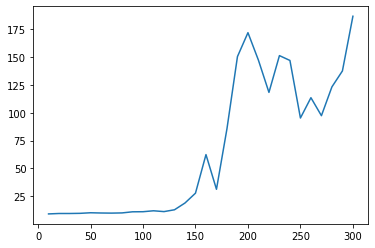

In [ ]:
# Running the training and evaluation
from tensorflow.keras import backend as be
be.clear_session()
pms = Parameters()
dqn = Dqn(pms)
ep_ids, returns = dqn.train_function()
plt.plot(ep_ids, returns)
dqn.evaluation(video=False)
dqn.close()

## Summary for Learning Rates
I tried multiple learning rates and kept all the other parameters of the DQN system as default. I explored learning rates both higher and lower than the default values. The Learning rates which were higher than default (lr = 0.0001) were 0.01, 0.001 and learning rate lower than default was 0.00005. In all the cases the DQN converged. The interesting thing was that in learning rates which were higher than default 0.01 and 0.001 converged quickly with around 130 episodes and with lower learning rate of 0.00005 it took around 300 episodes to converge which was more than default (lr = 0.0001) case which was around 190 episodes. Hence it seems the optimal learning rate for the system is around 0.001 which is way higher than the default value.

## Exploring Different Values of C (Frequency of Synchronizing)

In [ ]:
#C = 150
class Parameters:

    def __init__(self):
                                 # Default values
        self.buf_size = 5000     # 5000
        self.batch = 256         # 256
        self.epoch = 5           # 5
        self.max_ep = 500        # 500
        self.eps = 0.5           # 0.5
        self.gamma = 0.9         # 0.9
        self.C = 150             # 100
        self.train_freq = 1      # 1
        self.eval_freq = 10      # 10
        self.net = [(128, 'relu'), (128, 'relu'), (2, 'relu')] # [(128, 'relu'), (128, 'relu'), (2, 'relu')]
        self.lr = 0.0001         # 0.0001
        self.opt = Optimizer.ADAM # Optimizer.ADAM

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Initialization was finished.
Training was started.

Episode Id: 10 Return during training: 21.0
Episode Id: 20 Return during training: 10.0
Episode Id: 30 Return during training: 8.0
Episode Id: 40 Return during training: 10.0
Episode Id: 50 Return during training: 12.0
Episode Id: 60 Return during training: 11.0
Episode Id: 70 Return during training: 11.0
Episode Id: 80 Return during training: 16.0
Episode Id: 90 Return during training: 32.0
Episode Id: 100 Return during training: 31.0
Episode Id: 110 Return during training: 36.0
Episode Id: 120 Return during training: 51.0
Episode Id: 130 Return during training: 73.0
Episode Id: 140 Return during training: 90.0
Episode Id: 150 Return during training: 113.0
Episode Id: 160 Return during training: 119.0
Episode Id: 170 Return during training: 69.0
Episode Id: 180 Return during training: 39.0
Training was finished.


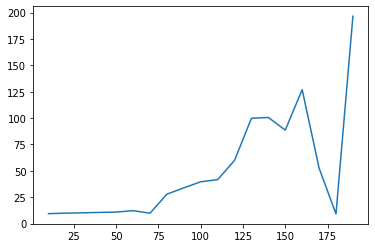

In [ ]:
# Running the training and evaluation
from tensorflow.keras import backend as be
be.clear_session()
pms = Parameters()
dqn = Dqn(pms)
ep_ids, returns = dqn.train_function()
plt.plot(ep_ids, returns)
dqn.evaluation(video=False)
dqn.close()

In [ ]:
#C = 50
class Parameters:

    def __init__(self):
                                 # Default values
        self.buf_size = 5000     # 5000
        self.batch = 256         # 256
        self.epoch = 5           # 5
        self.max_ep = 500        # 500
        self.eps = 0.5           # 0.5
        self.gamma = 0.9         # 0.9
        self.C = 50             # 100
        self.train_freq = 1      # 1
        self.eval_freq = 10      # 10
        self.net = [(128, 'relu'), (128, 'relu'), (2, 'relu')] # [(128, 'relu'), (128, 'relu'), (2, 'relu')]
        self.lr = 0.0001         # 0.0001
        self.opt = Optimizer.ADAM # Optimizer.ADAM

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Initialization was finished.
Training was started.

Episode Id: 10 Return during training: 10.0
Episode Id: 20 Return during training: 13.0
Episode Id: 30 Return during training: 10.0
Episode Id: 40 Return during training: 8.0
Episode Id: 50 Return during training: 11.0
Episode Id: 60 Return during training: 11.0
Episode Id: 70 Return during training: 14.0
Episode Id: 80 Return during training: 25.0
Episode Id: 90 Return during training: 60.0
Episode Id: 100 Return during training: 35.0
Episode Id: 110 Return during training: 101.0
Episode Id: 120 Return during training: 76.0
Episode Id: 130 Return during training: 117.0
Episode Id: 140 Return during training: 42.0
Episode Id: 150 Return during training: 140.0
Episode Id: 160 Return during training: 29.0
Episode Id: 170 Return during training: 123.0
Episode Id: 180 Return during training: 180.0
Episode Id: 190 Return during training: 27.0
Episode Id: 200 R

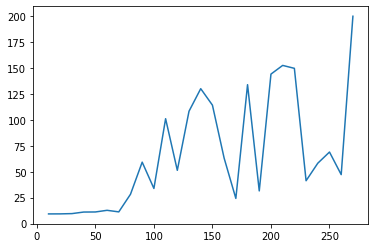

In [ ]:
# Running the training and evaluation
from tensorflow.keras import backend as be
be.clear_session()
pms = Parameters()
dqn = Dqn(pms)
ep_ids, returns = dqn.train_function()
plt.plot(ep_ids, returns)
dqn.evaluation(video=False)
dqn.close()

## Summary for Frequency of Synchronizing

In this I tried values of C = 50 and 150 both 50 lower and higher than the default value of 100.Rest of the parameters were kept as default. In both the cases the DQN system converged. In the case of C = 150 the system converges around the same time as default value system as it takes around 190 episodes . In case of C = 50 the system takes around 270 episodes and the return during training is very erratic as well. Hence, it seems like the default value of C is optimal. 

## Exploration : Epsilion

In [ ]:
#epsilon = 0.8
class Parameters:

    def __init__(self):
                                 # Default values
        self.buf_size = 5000     # 5000
        self.batch = 256         # 256
        self.epoch = 5           # 5
        self.max_ep = 500        # 500
        self.eps = 0.8           # 0.5
        self.gamma = 0.9         # 0.9
        self.C = 100             # 100
        self.train_freq = 1      # 1
        self.eval_freq = 10      # 10
        self.net = [(128, 'relu'), (128, 'relu'), (2, 'relu')] # [(128, 'relu'), (128, 'relu'), (2, 'relu')]
        self.lr = 0.0001         # 0.0001
        self.opt = Optimizer.ADAM # Optimizer.ADAM

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Initialization was finished.
Training was started.

Episode Id: 10 Return during training: 14.0
Episode Id: 20 Return during training: 26.0
Episode Id: 30 Return during training: 14.0
Episode Id: 40 Return during training: 11.0
Episode Id: 50 Return during training: 8.0
Episode Id: 60 Return during training: 12.0
Episode Id: 70 Return during training: 38.0
Episode Id: 80 Return during training: 100.0
Episode Id: 90 Return during training: 151.0
Episode Id: 100 Return during training: 200.0
Episode Id: 110 Return during training: 143.0
Episode Id: 120 Return during training: 170.0
Episode Id: 130 Return during training: 27.0
Training was finished.


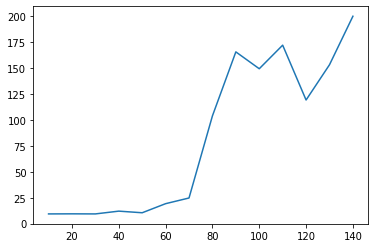

In [ ]:
# Running the training and evaluation
from tensorflow.keras import backend as be
be.clear_session()
pms = Parameters()
dqn = Dqn(pms)
ep_ids, returns = dqn.train_function()
plt.plot(ep_ids, returns)
dqn.evaluation(video=False)
dqn.close()

In [ ]:
#epsilon = 0.3
class Parameters:

    def __init__(self):
                                 # Default values
        self.buf_size = 5000     # 5000
        self.batch = 256         # 256
        self.epoch = 5           # 5
        self.max_ep = 500        # 500
        self.eps = 0.3           # 0.5
        self.gamma = 0.9         # 0.9
        self.C = 100             # 100
        self.train_freq = 1      # 1
        self.eval_freq = 10      # 10
        self.net = [(128, 'relu'), (128, 'relu'), (2, 'relu')] # [(128, 'relu'), (128, 'relu'), (2, 'relu')]
        self.lr = 0.0001         # 0.0001
        self.opt = Optimizer.ADAM # Optimizer.ADAM

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Initialization was finished.
Training was started.

Episode Id: 10 Return during training: 13.0
Episode Id: 20 Return during training: 12.0
Episode Id: 30 Return during training: 8.0
Episode Id: 40 Return during training: 11.0
Episode Id: 50 Return during training: 12.0
Episode Id: 60 Return during training: 12.0
Episode Id: 70 Return during training: 9.0
Episode Id: 80 Return during training: 15.0
Episode Id: 90 Return during training: 38.0
Episode Id: 100 Return during training: 125.0
Episode Id: 110 Return during training: 124.0
Episode Id: 120 Return during training: 12.0
Episode Id: 130 Return during training: 9.0
Episode Id: 140 Return during training: 10.0
Episode Id: 150 Return during training: 14.0
Episode Id: 160 Return during training: 17.0
Episode Id: 170 Return during training: 180.0
Episode Id: 180 Return during training: 95.0
Episode Id: 190 Return during training: 200.0
Episode Id: 200 Retu

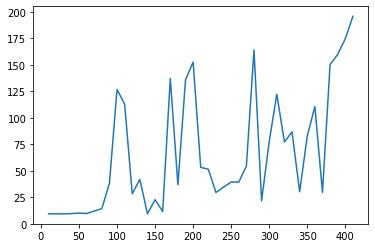

In [ ]:
# Running the training and evaluation
from tensorflow.keras import backend as be
be.clear_session()
pms = Parameters()
dqn = Dqn(pms)
ep_ids, returns = dqn.train_function()
plt.plot(ep_ids, returns)
dqn.evaluation(video=False)
dqn.close()

## Summary for Epsilon
Epsilons tried were both higher and lower than the default value of 0.5. The value higher than default was 0.8 and lower was 0.3. Rest parameters were set to default. In both the cases the system converged. It took around 130 episodes to converge for epsilon = 0.8, which is much lower than default of around 190 episodes and the convergence is very smooth as we can see from the plots. In case of epsilon = 0.3 it took around 400 episodes for the system to converge, which is way more than the defualt system and the convergence was very erratic as we can see from the plot. Hence, it can be seen higher the value of epsilon better the convergence.

##Exploring: Train Frequency

In [ ]:
#Train Frequency = 5
class Parameters:

    def __init__(self):
                                 # Default values
        self.buf_size = 5000     # 5000
        self.batch = 256         # 256
        self.epoch = 5           # 5
        self.max_ep = 500        # 500
        self.eps = 0.5           # 0.5
        self.gamma = 0.9         # 0.9
        self.C = 100             # 100
        self.train_freq = 5      # 1
        self.eval_freq = 10      # 10
        self.net = [(128, 'relu'), (128, 'relu'), (2, 'relu')] # [(128, 'relu'), (128, 'relu'), (2, 'relu')]
        self.lr = 0.0001         # 0.0001
        self.opt = Optimizer.ADAM # Optimizer.ADAM

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Initialization was finished.
Training was started.

Episode Id: 10 Return during training: 33.0
Episode Id: 20 Return during training: 10.0
Episode Id: 30 Return during training: 14.0
Episode Id: 40 Return during training: 8.0
Episode Id: 50 Return during training: 9.0
Episode Id: 60 Return during training: 11.0
Episode Id: 70 Return during training: 8.0
Episode Id: 80 Return during training: 9.0
Episode Id: 90 Return during training: 9.0
Episode Id: 100 Return during training: 8.0
Episode Id: 110 Return during training: 8.0
Episode Id: 120 Return during training: 10.0
Episode Id: 130 Return during training: 9.0
Episode Id: 140 Return during training: 10.0
Episode Id: 150 Return during training: 8.0
Episode Id: 160 Return during training: 10.0
Episode Id: 170 Return during training: 10.0
Episode Id: 180 Return during training: 8.0
Episode Id: 190 Return during training: 10.0
Episode Id: 200 Return during t

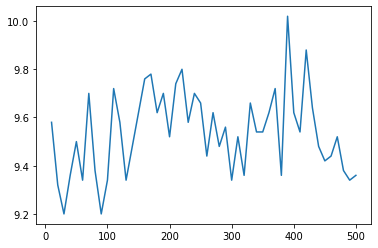

In [ ]:
# Running the training and evaluation
from tensorflow.keras import backend as be
be.clear_session()
pms = Parameters()
dqn = Dqn(pms)
ep_ids, returns = dqn.train_function()
plt.plot(ep_ids, returns)
dqn.evaluation(video=False)
dqn.close()

In [ ]:
#Train Frequency = 10
class Parameters:

    def __init__(self):
                                 # Default values
        self.buf_size = 5000     # 5000
        self.batch = 256         # 256
        self.epoch = 5           # 5
        self.max_ep = 500        # 500
        self.eps = 0.5           # 0.5
        self.gamma = 0.9         # 0.9
        self.C = 100             # 100
        self.train_freq = 10      # 1
        self.eval_freq = 10      # 10
        self.net = [(128, 'relu'), (128, 'relu'), (2, 'relu')] # [(128, 'relu'), (128, 'relu'), (2, 'relu')]
        self.lr = 0.0001         # 0.0001
        self.opt = Optimizer.ADAM # Optimizer.ADAM

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Initialization was finished.
Training was started.

Episode Id: 10 Return during training: 19.0
Episode Id: 20 Return during training: 9.0
Episode Id: 30 Return during training: 11.0
Episode Id: 40 Return during training: 12.0
Episode Id: 50 Return during training: 8.0
Episode Id: 60 Return during training: 12.0
Episode Id: 70 Return during training: 10.0
Episode Id: 80 Return during training: 9.0
Episode Id: 90 Return during training: 10.0
Episode Id: 100 Return during training: 10.0
Episode Id: 110 Return during training: 10.0
Episode Id: 120 Return during training: 9.0
Episode Id: 130 Return during training: 10.0
Episode Id: 140 Return during training: 11.0
Episode Id: 150 Return during training: 10.0
Episode Id: 160 Return during training: 9.0
Episode Id: 170 Return during training: 10.0
Episode Id: 180 Return during training: 11.0
Episode Id: 190 Return during training: 10.0
Episode Id: 200 Return dur

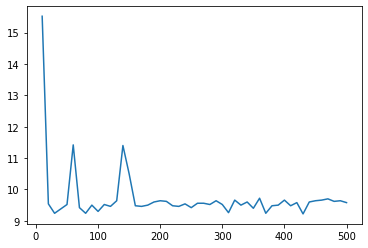

In [ ]:
# Running the training and evaluation
from tensorflow.keras import backend as be
be.clear_session()
pms = Parameters()
dqn = Dqn(pms)
ep_ids, returns = dqn.train_function()
plt.plot(ep_ids, returns)
dqn.evaluation(video=False)
dqn.close()

## Summary for train frequency

We tried the train frequency value of 5 and 10 in both the cases the system did not converge hence, it seems like it needs to train with different set of values.

P.S. More exploration towards the end.

## Exploring: Net.  
## Neurons

In [ ]:
#Neurons
class Parameters:

    def __init__(self):
                                 # Default values
        self.buf_size = 5000     # 5000
        self.batch = 256         # 256
        self.epoch = 5           # 5
        self.max_ep = 500        # 500
        self.eps = 0.5           # 0.5
        self.gamma = 0.9         # 0.9
        self.C = 100             # 100
        self.train_freq = 1      # 1
        self.eval_freq = 10      # 10
        self.net = [(64, 'relu'), (64, 'relu'), (2, 'relu')] # [(128, 'relu'), (128, 'relu'), (2, 'relu')]
        self.lr = 0.0001         # 0.0001
        self.opt = Optimizer.ADAM # Optimizer.ADAM

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Initialization was finished.
Training was started.

Episode Id: 10 Return during training: 12.0
Episode Id: 20 Return during training: 13.0
Episode Id: 30 Return during training: 11.0
Episode Id: 40 Return during training: 8.0
Episode Id: 50 Return during training: 12.0
Episode Id: 60 Return during training: 12.0
Episode Id: 70 Return during training: 13.0
Episode Id: 80 Return during training: 13.0
Episode Id: 90 Return during training: 33.0
Episode Id: 100 Return during training: 38.0
Episode Id: 110 Return during training: 42.0
Episode Id: 120 Return during training: 38.0
Episode Id: 130 Return during training: 49.0
Episode Id: 140 Return during training: 56.0
Episode Id: 150 Return during training: 68.0
Episode Id: 160 Return during training: 70.0
Episode Id: 170 Return during training: 107.0
Episode Id: 180 Return during training: 105.0
Episode Id: 190 Return during training: 72.0
Episode Id: 200 Retu

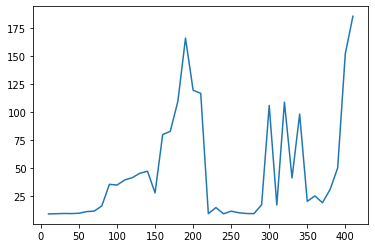

In [ ]:
# Running the training and evaluation
from tensorflow.keras import backend as be
be.clear_session()
pms = Parameters()
dqn = Dqn(pms)
ep_ids, returns = dqn.train_function()
plt.plot(ep_ids, returns)
dqn.evaluation(video=False)
dqn.close()

In [ ]:
#Neurons
class Parameters:

    def __init__(self):
                                 # Default values
        self.buf_size = 5000     # 5000
        self.batch = 256         # 256
        self.epoch = 5           # 5
        self.max_ep = 500        # 500
        self.eps = 0.5           # 0.5
        self.gamma = 0.9         # 0.9
        self.C = 100             # 100
        self.train_freq = 1      # 1
        self.eval_freq = 10      # 10
        self.net = [(256, 'relu'), (256, 'relu'), (2, 'relu')] # [(128, 'relu'), (128, 'relu'), (2, 'relu')]
        self.lr = 0.0001         # 0.0001
        self.opt = Optimizer.ADAM # Optimizer.ADAM

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Initialization was finished.
Training was started.

Episode Id: 10 Return during training: 13.0
Episode Id: 20 Return during training: 14.0
Episode Id: 30 Return during training: 9.0
Episode Id: 40 Return during training: 13.0
Episode Id: 50 Return during training: 11.0
Episode Id: 60 Return during training: 13.0
Episode Id: 70 Return during training: 28.0
Episode Id: 80 Return during training: 25.0
Episode Id: 90 Return during training: 200.0
Episode Id: 100 Return during training: 62.0
Episode Id: 110 Return during training: 129.0
Episode Id: 120 Return during training: 135.0
Episode Id: 130 Return during training: 52.0
Training was finished.


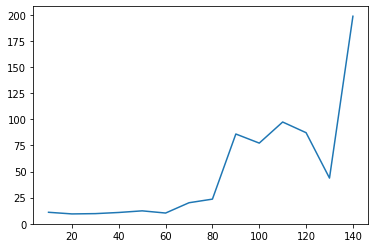

In [ ]:
# Running the training and evaluation
from tensorflow.keras import backend as be
be.clear_session()
pms = Parameters()
dqn = Dqn(pms)
ep_ids, returns = dqn.train_function()
plt.plot(ep_ids, returns)
dqn.evaluation(video=False)
dqn.close()

## Summary of Neurons

I tried 2 different values for the number of neurons in the neural network for the system one higher (256) and one lower (64) than the default value of 128. Rest of the parameters were kept the same. In both the cases the system converged. The one with the lower number of neurons (64) took around 400 episodes and was very irratic as well compared to one with higher number of neurons (256). The system with the higher number of neurons seem to be less erratic and converges quicky compared to default system and the system with lower neurons. Hence, it seems higher the neurons the better the system.

## Activation function

In [ ]:
#Activation = elu
class Parameters:

    def __init__(self):
                                 # Default values
        self.buf_size = 5000     # 5000
        self.batch = 256         # 256
        self.epoch = 5           # 5
        self.max_ep = 500        # 500
        self.eps = 0.5           # 0.5
        self.gamma = 0.9         # 0.9
        self.C = 100             # 100
        self.train_freq = 1      # 1
        self.eval_freq = 10      # 10
        self.net = [(128, 'elu'), (128, 'elu'), (2, 'elu')] # [(128, 'relu'), (128, 'relu'), (2, 'relu')]
        self.lr = 0.0001         # 0.0001
        self.opt = Optimizer.ADAM # Optimizer.ADAM

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Initialization was finished.
Training was started.

Episode Id: 10 Return during training: 10.0
Episode Id: 20 Return during training: 11.0
Episode Id: 30 Return during training: 12.0
Episode Id: 40 Return during training: 10.0
Episode Id: 50 Return during training: 8.0
Episode Id: 60 Return during training: 9.0
Episode Id: 70 Return during training: 9.0
Episode Id: 80 Return during training: 10.0
Episode Id: 90 Return during training: 9.0
Episode Id: 100 Return during training: 11.0
Episode Id: 110 Return during training: 10.0
Episode Id: 120 Return during training: 11.0
Episode Id: 130 Return during training: 9.0
Episode Id: 140 Return during training: 11.0
Episode Id: 150 Return during training: 10.0
Episode Id: 160 Return during training: 11.0
Episode Id: 170 Return during training: 12.0
Episode Id: 180 Return during training: 10.0
Episode Id: 190 Return during training: 9.0
Episode Id: 200 Return duri

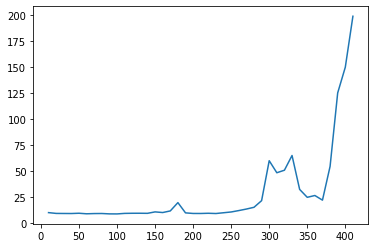

In [ ]:
# Running the training and evaluation
from tensorflow.keras import backend as be
be.clear_session()
pms = Parameters()
dqn = Dqn(pms)
ep_ids, returns = dqn.train_function()
plt.plot(ep_ids, returns)
dqn.evaluation(video=False)
dqn.close()

## Summary for Activation Functions

I tried a different activation function elu and kept rest of the parameters as default. As we can see in the plot the DQN sytem was not able to converge at the beginning but after 250 episodes it started to converge and around 400 episodes it converged to the optimal return value. The system converges with elu as well but it takes way longer than the relu function.

## Exploring Epochs

In [ ]:
#epochs = 3
class Parameters:

    def __init__(self):
                                 # Default values
        self.buf_size = 5000     # 5000
        self.batch = 256         # 256
        self.epoch = 3           # 5
        self.max_ep = 500        # 500
        self.eps = 0.5           # 0.5
        self.gamma = 0.9         # 0.9
        self.C = 100             # 100
        self.train_freq = 1      # 1
        self.eval_freq = 10      # 10
        self.net = [(128, 'relu'), (128, 'relu'), (2, 'relu')] # [(128, 'relu'), (128, 'relu'), (2, 'relu')]
        self.lr = 0.0001         # 0.0001
        self.opt = Optimizer.ADAM # Optimizer.ADAM

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Initialization was finished.
Training was started.

Episode Id: 10 Return during training: 14.0
Episode Id: 20 Return during training: 10.0
Episode Id: 30 Return during training: 12.0
Episode Id: 40 Return during training: 9.0
Episode Id: 50 Return during training: 10.0
Episode Id: 60 Return during training: 11.0
Episode Id: 70 Return during training: 9.0
Episode Id: 80 Return during training: 11.0
Episode Id: 90 Return during training: 12.0
Episode Id: 100 Return during training: 10.0
Episode Id: 110 Return during training: 13.0
Episode Id: 120 Return during training: 16.0
Episode Id: 130 Return during training: 16.0
Episode Id: 140 Return during training: 21.0
Episode Id: 150 Return during training: 43.0
Episode Id: 160 Return during training: 74.0
Episode Id: 170 Return during training: 56.0
Episode Id: 180 Return during training: 31.0
Episode Id: 190 Return during training: 105.0
Episode Id: 200 Return

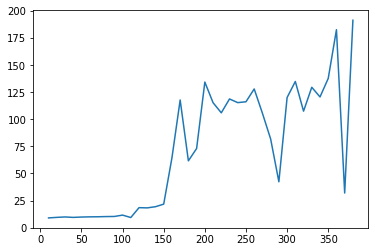

In [ ]:
# Running the training and evaluation
from tensorflow.keras import backend as be
be.clear_session()
pms = Parameters()
dqn = Dqn(pms)
ep_ids, returns = dqn.train_function()
plt.plot(ep_ids, returns)
dqn.evaluation(video=False)
dqn.close()

In [ ]:
#epochs = 8
class Parameters:

    def __init__(self):
                                 # Default values
        self.buf_size = 5000     # 5000
        self.batch = 256         # 256
        self.epoch = 8           # 5
        self.max_ep = 500        # 500
        self.eps = 0.5           # 0.5
        self.gamma = 0.9         # 0.9
        self.C = 100             # 100
        self.train_freq = 1      # 1
        self.eval_freq = 10      # 10
        self.net = [(128, 'relu'), (128, 'relu'), (2, 'relu')] # [(128, 'relu'), (128, 'relu'), (2, 'relu')]
        self.lr = 0.0001         # 0.0001
        self.opt = Optimizer.ADAM # Optimizer.ADAM

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Initialization was finished.
Training was started.

Episode Id: 10 Return during training: 14.0
Episode Id: 20 Return during training: 11.0
Episode Id: 30 Return during training: 12.0
Episode Id: 40 Return during training: 11.0
Episode Id: 50 Return during training: 9.0
Episode Id: 60 Return during training: 32.0
Episode Id: 70 Return during training: 113.0
Episode Id: 80 Return during training: 73.0
Episode Id: 90 Return during training: 163.0
Episode Id: 100 Return during training: 126.0
Episode Id: 110 Return during training: 123.0
Episode Id: 120 Return during training: 11.0
Episode Id: 130 Return during training: 126.0
Episode Id: 140 Return during training: 106.0
Episode Id: 150 Return during training: 111.0
Episode Id: 160 Return during training: 103.0
Episode Id: 170 Return during training: 77.0
Episode Id: 180 Return during training: 119.0
Episode Id: 190 Return during training: 200.0
Episode Id: 

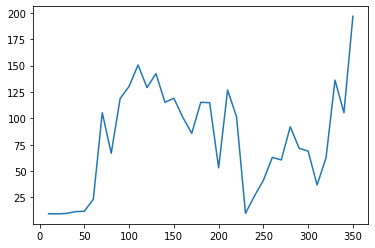

In [ ]:
# Running the training and evaluation
from tensorflow.keras import backend as be
be.clear_session()
pms = Parameters()
dqn = Dqn(pms)
ep_ids, returns = dqn.train_function()
plt.plot(ep_ids, returns)
dqn.evaluation(video=False)
dqn.close()

## Summary for Epochs

In both the cases of epochs lower (3) and higher (8) than default value of 5 the DQN system converged to required optimal return for over 300 episode which is more than the default DQN convergence of around 190 episode and both higher epoch and lower epoch DQN system seem to be very erratic in terms of learning. Hence the default value seem to be just right. 

## Exploring Evaluation Frequency

In [ ]:
#Evaluating Frequency = 5
class Parameters:

    def __init__(self):
                                 # Default values
        self.buf_size = 5000     # 5000
        self.batch = 256         # 256
        self.epoch = 5           # 5
        self.max_ep = 500        # 500
        self.eps = 0.5           # 0.5
        self.gamma = 0.9         # 0.9
        self.C = 100             # 100
        self.train_freq = 1      # 1
        self.eval_freq = 5      # 10
        self.net = [(128, 'relu'), (128, 'relu'), (2, 'relu')] # [(128, 'relu'), (128, 'relu'), (2, 'relu')]
        self.lr = 0.0001         # 0.0001
        self.opt = Optimizer.ADAM # Optimizer.ADAM

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Initialization was finished.
Training was started.

Episode Id: 10 Return during training: 10.0
Episode Id: 20 Return during training: 10.0
Episode Id: 30 Return during training: 10.0
Episode Id: 40 Return during training: 10.0
Episode Id: 50 Return during training: 10.0
Episode Id: 60 Return during training: 9.0
Episode Id: 70 Return during training: 9.0
Episode Id: 80 Return during training: 10.0
Episode Id: 90 Return during training: 10.0
Episode Id: 100 Return during training: 9.0
Episode Id: 110 Return during training: 10.0
Episode Id: 120 Return during training: 10.0
Episode Id: 130 Return during training: 10.0
Episode Id: 140 Return during training: 9.0
Episode Id: 150 Return during training: 9.0
Episode Id: 160 Return during training: 9.0
Episode Id: 170 Return during training: 9.0
Episode Id: 180 Return during training: 10.0
Episode Id: 190 Return during training: 9.0
Episode Id: 200 Return during

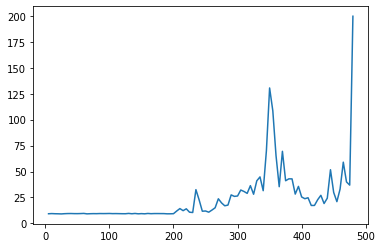

In [ ]:
# Running the training and evaluation
from tensorflow.keras import backend as be
be.clear_session()
pms = Parameters()
dqn = Dqn(pms)
ep_ids, returns = dqn.train_function()
plt.plot(ep_ids, returns)
dqn.evaluation(video=False)
dqn.close()

In [ ]:
#Evaluating Frequency = 15
class Parameters:

    def __init__(self):
                                 # Default values
        self.buf_size = 5000     # 5000
        self.batch = 256         # 256
        self.epoch = 5           # 5
        self.max_ep = 500        # 500
        self.eps = 0.5           # 0.5
        self.gamma = 0.9         # 0.9
        self.C = 100             # 100
        self.train_freq = 1      # 1
        self.eval_freq = 15      # 10
        self.net = [(128, 'relu'), (128, 'relu'), (2, 'relu')] # [(128, 'relu'), (128, 'relu'), (2, 'relu')]
        self.lr = 0.0001         # 0.0001
        self.opt = Optimizer.ADAM # Optimizer.ADAM

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Initialization was finished.
Training was started.

Episode Id: 10 Return during training: 12.0
Episode Id: 20 Return during training: 11.0
Episode Id: 30 Return during training: 11.0
Episode Id: 40 Return during training: 11.0
Episode Id: 50 Return during training: 13.0
Episode Id: 60 Return during training: 16.0
Episode Id: 70 Return during training: 33.0
Episode Id: 80 Return during training: 33.0
Episode Id: 90 Return during training: 35.0
Episode Id: 100 Return during training: 49.0
Episode Id: 110 Return during training: 37.0
Episode Id: 120 Return during training: 26.0
Episode Id: 130 Return during training: 51.0
Episode Id: 140 Return during training: 41.0
Episode Id: 150 Return during training: 45.0
Episode Id: 160 Return during training: 58.0
Episode Id: 170 Return during training: 76.0
Episode Id: 180 Return during training: 57.0
Episode Id: 190 Return during training: 111.0
Episode Id: 200 Retu

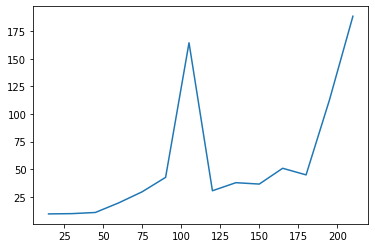

In [ ]:
# Running the training and evaluation
from tensorflow.keras import backend as be
be.clear_session()
pms = Parameters()
dqn = Dqn(pms)
ep_ids, returns = dqn.train_function()
plt.plot(ep_ids, returns)
dqn.evaluation(video=False)
dqn.close()

## Summary for evaluating frequency: 
I tried evaluating frequency both lower (5) and higher (15) than the default value (10).Rest all the parameters were kept the same. In case of the lower frequency the DQN system became very erratic and converged after 470 episodes which is way higher than the default DQN system convergence. In terms of higher value of evaluating frequency the system is quite smooth and not very erratic and takes around the same amount of episodes compared to default DQN system. Hence, the default system seem to be most stable in terms of evaluating frequency


## Trying different combination of parmeters

## Converging DQN with SGD

In [ ]:
#SGD with high episode value, high buffer size, high neuron value, higher neuron and learning rate, C value, epsilon
class Parameters:

    def __init__(self):
                                 # Default values
        self.buf_size = 15000     # 5000
        self.batch =  256        # 256
        self.epoch = 10           # 5
        self.max_ep = 5000        # 500
        self.eps = 0.8           # 0.5
        self.gamma = 0.95         # 0.9
        self.C = 150             # 100
        self.train_freq = 1      # 1
        self.eval_freq = 10      # 10
        self.net = [(256, 'relu'), (256, 'relu'), (2, 'relu')] # [(128, 'relu'), (128, 'relu'), (2, 'relu')]
        self.lr = 0.001         # 0.0001
        self.opt = Optimizer.SGD # Optimizer.ADAM

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Initialization was finished.
Training was started.

Episode Id: 10 Return during training: 35.0
Episode Id: 20 Return during training: 14.0
Episode Id: 30 Return during training: 11.0
Episode Id: 40 Return during training: 15.0
Episode Id: 50 Return during training: 9.0
Episode Id: 60 Return during training: 10.0
Episode Id: 70 Return during training: 10.0
Episode Id: 80 Return during training: 9.0
Episode Id: 90 Return during training: 10.0
Episode Id: 100 Return during training: 9.0
Episode Id: 110 Return during training: 9.0
Episode Id: 120 Return during training: 9.0
Episode Id: 130 Return during training: 12.0
Episode Id: 140 Return during training: 8.0
Episode Id: 150 Return during training: 9.0
Episode Id: 160 Return during training: 10.0
Episode Id: 170 Return during training: 10.0
Episode Id: 180 Return during training: 9.0
Episode Id: 190 Return during training: 8.0
Episode Id: 200 Return during 

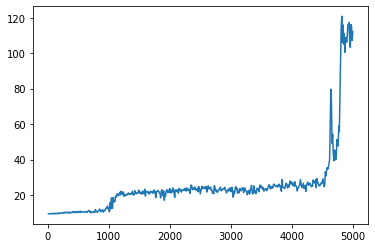

In [ ]:
# Running the training and evaluation
from tensorflow.keras import backend as be
be.clear_session()
pms = Parameters()
dqn = Dqn(pms)
ep_ids, returns = dqn.train_function()
plt.plot(ep_ids, returns)
dqn.evaluation(video=False)
dqn.close()

## Summary for SGD
I used the best parameters derived from above explorations (high buffer size (15000), high epsilon(0.8), high gamma(0.95), high number of neurons(256)). We can see by the end of 5000 episodes the SGD optimizer has also started to converge to the required return value. The highest value of 131  return was achieved . So, it seems like  it will converge to the required value for a higher number of episodes as well.

## Converging DQN with different Train Frequency

The DQN did not converge in 500 episodes with varied values of train frequency (5,10) and keeping the rest of the values as default. So, now we try to converge this DQN with different values other than the default values.

In [ ]:
#Train Frequency = 5
class Parameters:

    def __init__(self):
                                 # Default values
        self.buf_size = 10000     # 5000
        self.batch =  256        # 256
        self.epoch = 10           # 5
        self.max_ep = 1000        # 500
        self.eps = 0.8           # 0.5
        self.gamma = 0.95         # 0.9
        self.C = 100             # 100
        self.train_freq = 5      # 1
        self.eval_freq = 10      # 10
        self.net = [(256, 'relu'), (256, 'relu'), (2, 'relu')] # [(128, 'relu'), (128, 'relu'), (2, 'relu')]
        self.lr = 0.0001         # 0.0001
        self.opt = Optimizer.ADAM # Optimizer.ADAM

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Initialization was finished.
Training was started.

Episode Id: 10 Return during training: 15.0
Episode Id: 20 Return during training: 12.0
Episode Id: 30 Return during training: 13.0
Episode Id: 40 Return during training: 13.0
Episode Id: 50 Return during training: 10.0
Episode Id: 60 Return during training: 9.0
Episode Id: 70 Return during training: 10.0
Episode Id: 80 Return during training: 10.0
Episode Id: 90 Return during training: 9.0
Episode Id: 100 Return during training: 10.0
Episode Id: 110 Return during training: 17.0
Episode Id: 120 Return during training: 16.0
Episode Id: 130 Return during training: 10.0
Episode Id: 140 Return during training: 18.0
Episode Id: 150 Return during training: 16.0
Episode Id: 160 Return during training: 12.0
Episode Id: 170 Return during training: 11.0
Episode Id: 180 Return during training: 40.0
Episode Id: 190 Return during training: 42.0
Episode Id: 200 Return 

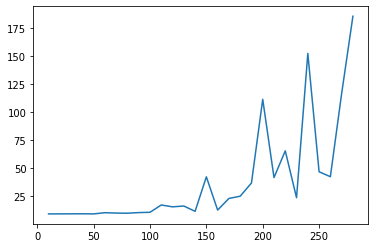

In [ ]:
# Running the training and evaluation
from tensorflow.keras import backend as be
be.clear_session()
pms = Parameters()
dqn = Dqn(pms)
ep_ids, returns = dqn.train_function()
plt.plot(ep_ids, returns)
dqn.evaluation(video=False)
dqn.close()

In [ ]:
#Train Frequency = 10
class Parameters:

    def __init__(self):
                                 # Default values
        self.buf_size = 10000     # 5000
        self.batch =  256        # 256
        self.epoch = 10           # 5
        self.max_ep = 1000        # 500
        self.eps = 0.8           # 0.5
        self.gamma = 0.95         # 0.9
        self.C = 100             # 100
        self.train_freq = 10      # 1
        self.eval_freq = 10      # 10
        self.net = [(256, 'relu'), (256, 'relu'), (2, 'relu')] # [(128, 'relu'), (128, 'relu'), (2, 'relu')]
        self.lr = 0.0001         # 0.0001
        self.opt = Optimizer.ADAM # Optimizer.ADAM

Initialization was finished.
Training was started.
Episode Id: 10 Return during training: 33.0
Episode Id: 20 Return during training: 13.0
Episode Id: 30 Return during training: 12.0
Episode Id: 40 Return during training: 13.0
Episode Id: 50 Return during training: 10.0
Episode Id: 60 Return during training: 10.0
Episode Id: 70 Return during training: 11.0
Episode Id: 80 Return during training: 14.0
Episode Id: 90 Return during training: 28.0
Episode Id: 100 Return during training: 11.0
Episode Id: 110 Return during training: 36.0
Episode Id: 120 Return during training: 53.0
Episode Id: 130 Return during training: 64.0
Episode Id: 140 Return during training: 59.0
Episode Id: 150 Return during training: 72.0
Episode Id: 160 Return during training: 64.0
Episode Id: 170 Return during training: 48.0
Episode Id: 180 Return during training: 116.0
Episode Id: 190 Return during training: 118.0
Episode Id: 200 Return during training: 121.0
Episode Id: 210 Return during training: 170.0
Episode I

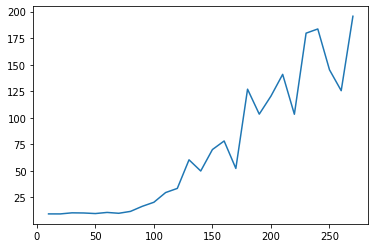

In [ ]:
# Running the training and evaluation
from tensorflow.keras import backend as be
import tensorflow as tf
be.clear_session()
tf.reset_default_graph()
pms = Parameters()
dqn = Dqn(pms)
ep_ids, returns = dqn.train_function()
plt.plot(ep_ids, returns)
dqn.evaluation(video=False)
dqn.close()

## Summary for train frequency

In earlier tries with values of train frequency of 5 and 10 and  rest of the values as default the DQN did not converge with 500 episodes. But now with changing the buffer size (10000), epochs (10), gamma (0.95), epsilon (0.8), neurons (256) to a higher value than default as these were found to be better for the DQN performance overall now the network converges in both the cases for the required return value in around 270 episodes in both the cases.

## Running some of the Best and Worst performing Parameters

In [ ]:
#Setting Parameters to some of the lowest performance parameters from previous observations
class Parameters:

    def __init__(self):
                                 # Default values
        self.buf_size = 2500     # 5000
        self.batch = 32         # 256
        self.epoch = 3           # 5
        self.max_ep = 5000        # 500
        self.eps = 0.3           # 0.5
        self.gamma = 0.85         # 0.9
        self.C = 50             # 100
        self.train_freq = 1      # 1
        self.eval_freq = 5      # 10
        self.net = [(64, 'relu'), (64, 'relu'), (2, 'relu')] # [(128, 'relu'), (128, 'relu'), (2, 'relu')]
        self.lr = 0.01         # 0.0001
        self.opt = Optimizer.ADAM # Optimizer.ADAM

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Initialization was finished.
Training was started.

Episode Id: 10 Return during training: 9.0
Episode Id: 20 Return during training: 11.0
Episode Id: 30 Return during training: 24.0
Episode Id: 40 Return during training: 15.0
Episode Id: 50 Return during training: 76.0
Episode Id: 60 Return during training: 15.0
Episode Id: 70 Return during training: 19.0
Episode Id: 80 Return during training: 29.0
Episode Id: 90 Return during training: 18.0
Episode Id: 100 Return during training: 11.0
Episode Id: 110 Return during training: 8.0
Episode Id: 120 Return during training: 9.0
Episode Id: 130 Return during training: 9.0
Episode Id: 140 Return during training: 12.0
Episode Id: 150 Return during training: 28.0
Episode Id: 160 Return during training: 10.0
Episode Id: 170 Return during training: 10.0
Episode Id: 180 Return during training: 11.0
Episode Id: 190 Return during training: 10.0
Episode Id: 200 Return du

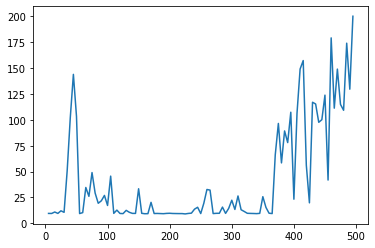

In [ ]:
# Running the training and evaluation
from tensorflow.keras import backend as be
import tensorflow as tf
be.clear_session()
tf.reset_default_graph()
pms = Parameters()
dqn = Dqn(pms)
ep_ids, returns = dqn.train_function()
plt.plot(ep_ids, returns)
dqn.evaluation(video=False)
dqn.close()

In [ ]:
#setting parameters to best parameters from previous explorations
class Parameters:

    def __init__(self):
                                 # Default values
        self.buf_size = 10000     # 5000
        self.batch = 256         # 512
        self.epoch = 5           # 5
        self.max_ep = 500        # 500
        self.eps = 0.8           # 0.5
        self.gamma = 0.95         # 0.9
        self.C = 150             # 100
        self.train_freq = 1      # 1
        self.eval_freq = 10      # 10
        self.net = [(256, 'relu'), (256, 'relu'), (2, 'relu')] # [(128, 'relu'), (128, 'relu'), (2, 'relu')]
        self.lr = 0.0001         # 0.0001
        self.opt = Optimizer.ADAM # Optimizer.ADAM

Initialization was finished.
Training was started.
Episode Id: 10 Return during training: 30.0
Episode Id: 20 Return during training: 10.0
Episode Id: 30 Return during training: 10.0
Episode Id: 40 Return during training: 11.0
Episode Id: 50 Return during training: 10.0
Episode Id: 60 Return during training: 28.0
Episode Id: 70 Return during training: 153.0
Episode Id: 80 Return during training: 31.0
Episode Id: 90 Return during training: 10.0
Episode Id: 100 Return during training: 152.0
Episode Id: 110 Return during training: 200.0
Episode Id: 120 Return during training: 200.0
Episode Id: 130 Return during training: 156.0
Training was finished.


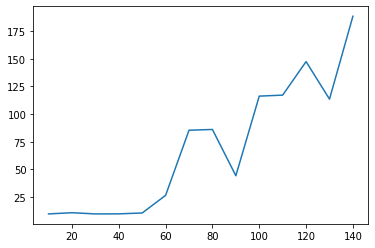

In [ ]:
# Running the training and evaluation
from tensorflow.keras import backend as be
import tensorflow as tf
be.clear_session()
tf.reset_default_graph()
pms = Parameters()
dqn = Dqn(pms)
ep_ids, returns = dqn.train_function()
plt.plot(ep_ids, returns)
dqn.evaluation(video=False)
dqn.close()

## Summary for best and worst parameters

In case of some of the best parameters the system converged pretty soon as expected and the learning was also quite linear in that case.

In case of some of the worst performing parameters the system was very erratic and took a long time to converge to the required return but the important take away is that the DQN still converged to the required return value.